# Case Study #2 : Morphological Image Processing
Identify ‘a’ in this picture

In [51]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

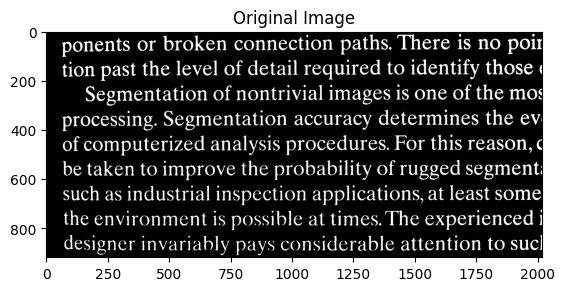

In [52]:
# Load image in grayscale
img = cv2.imread('case2_book.png', 0)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

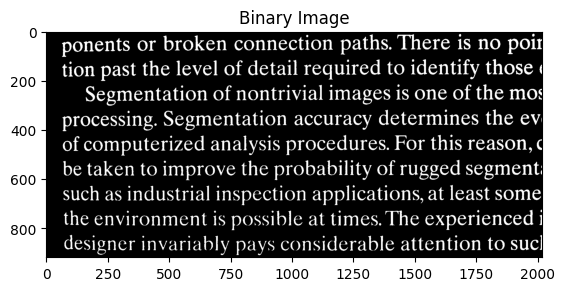

In [53]:
# Step 1: Binarize
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.show()

Found 24 'a' candidates for template
Selected template size: 36x41


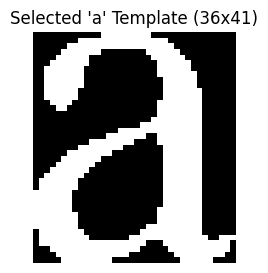

In [54]:
# Step 2: Find 'a' template using contour hierarchy
# 'a' has a hole (child contour) that sits in the LOWER half — this filters out 'e'
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
candidates = []

for i, cnt in enumerate(contours):
    child_idx = hierarchy[0][i][2]
    if child_idx == -1:
        continue

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h
    area = cv2.contourArea(cnt)

    if 100 < area < 1000 and 0.70 < aspect_ratio < 1.05:
        child_cnt = contours[child_idx]
        M = cv2.moments(child_cnt)
        if M['m00'] != 0:
            cy_child = int(M['m01'] / M['m00'])
            relative_hole_y = (cy_child - y) / h
            if relative_hole_y > 0.45:
                roi = binary[y:y+h, x:x+w]
                candidates.append(roi)

print(f"Found {len(candidates)} 'a' candidates for template")

# Pick the median-sized candidate as the template
candidates.sort(key=lambda c: c.size)
template = candidates[len(candidates) // 2]
h_temp, w_temp = template.shape
print(f"Selected template size: {w_temp}x{h_temp}")

plt.figure(figsize=(3, 3))
plt.imshow(template, cmap='gray')
plt.title(f"Selected 'a' Template ({w_temp}x{h_temp})")
plt.axis('off')
plt.show()

Found 260 matches (threshold=0.65)


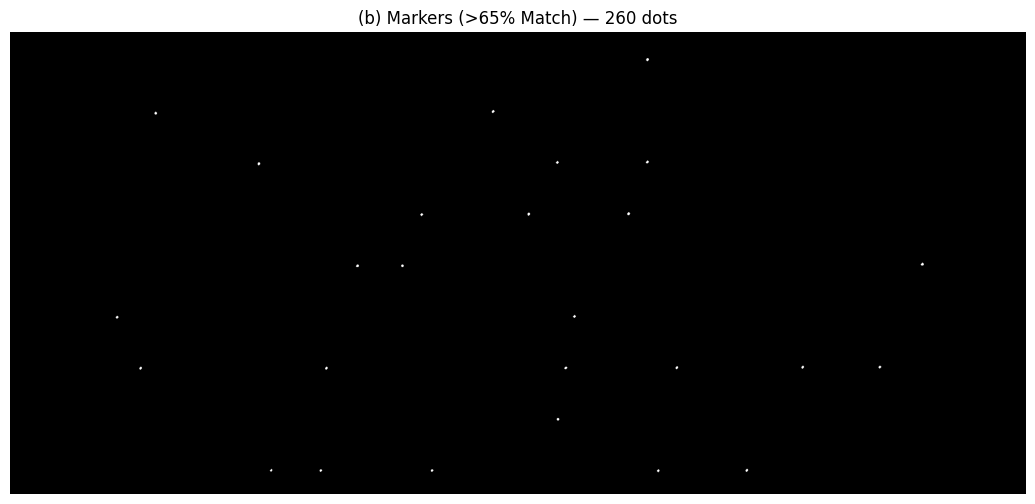

In [55]:
# Step 3 (b): Template Matching — find all 'a' locations (> 65% match)
res = cv2.matchTemplate(binary, template, cv2.TM_CCOEFF_NORMED)
threshold = 0.65
loc = np.where(res >= threshold)

# Create marker image: a single dot at the center of each match
marker = np.zeros_like(binary)
center_offset_x = w_temp // 2
center_offset_y = h_temp // 2

for pt in zip(*loc[::-1]):
    cx = pt[0] + center_offset_x
    cy = pt[1] + center_offset_y
    cv2.circle(marker, (cx, cy), 1, 255, -1)

print(f"Found {len(loc[0])} matches (threshold={threshold})")

plt.figure(figsize=(14, 6))
plt.imshow(marker, cmap='gray')
plt.title(f'(b) Markers (>{int(threshold*100)}% Match) — {len(loc[0])} dots')
plt.axis('off')
plt.show()

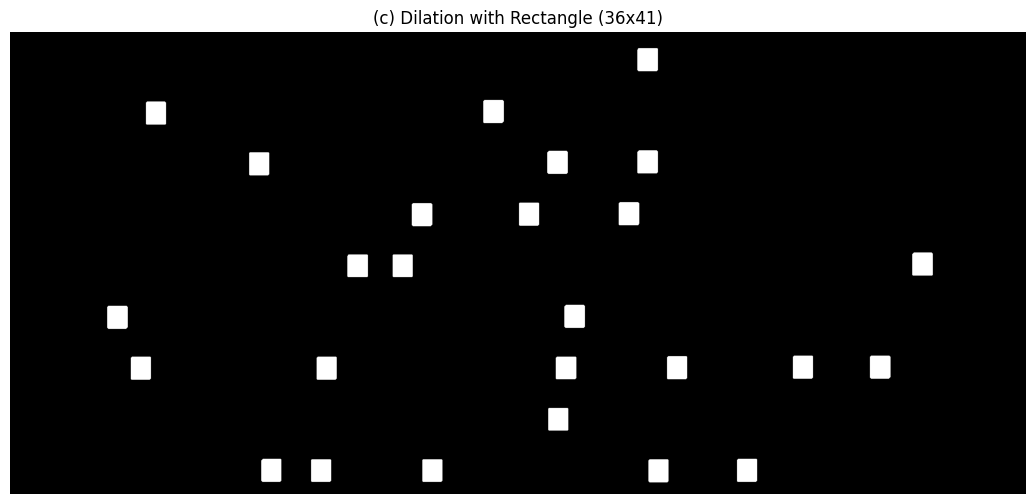

In [56]:
# Step 4 (c): Dilation with Rectangle kernel
# Expand each marker dot into a rectangle the size of the template
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (w_temp, h_temp))
dilated_rect = cv2.dilate(marker, rect_kernel)

plt.figure(figsize=(14, 6))
plt.imshow(dilated_rect, cmap='gray')
plt.title(f'(c) Dilation with Rectangle ({w_temp}x{h_temp})')
plt.axis('off')
plt.show()

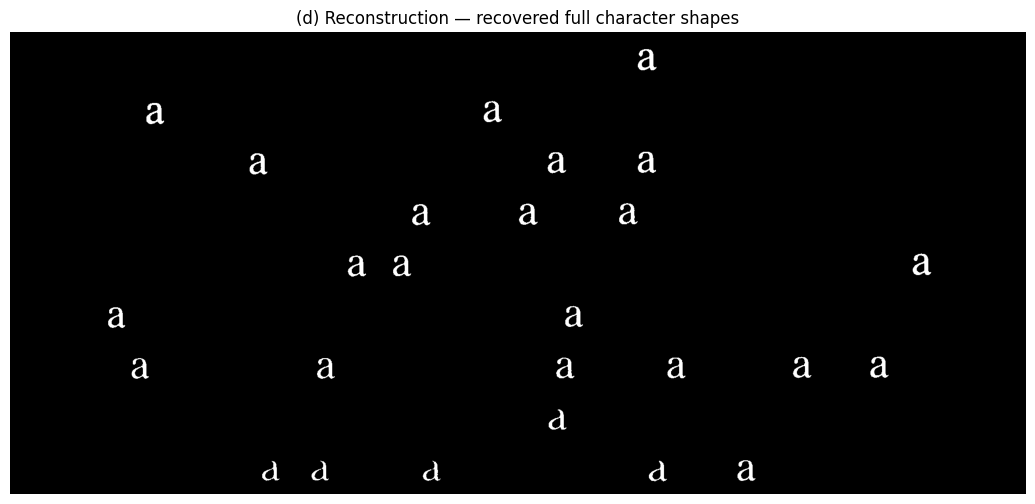

In [57]:
# Step 5 (d): Reconstruction via Connected Components
# Recover the FULL original character shape wherever a marker dot touches

def reconstruction_via_components(marker, mask):
    """
    Find connected components in the original (mask).
    If a marker pixel intersects a component, recover that entire component.
    """
    num_labels, labels_im = cv2.connectedComponents(mask, connectivity=8)
    reconstructed = np.zeros_like(mask)

    # Which component labels does the marker touch?
    hit_labels = np.unique(labels_im[marker == 255])

    for label in hit_labels:
        if label == 0:
            continue  # skip background
        reconstructed[labels_im == label] = 255

    return reconstructed

reconstruction_mask = reconstruction_via_components(marker, binary)

plt.figure(figsize=(14, 6))
plt.imshow(reconstruction_mask, cmap='gray')
plt.title('(d) Reconstruction — recovered full character shapes')
plt.axis('off')
plt.show()

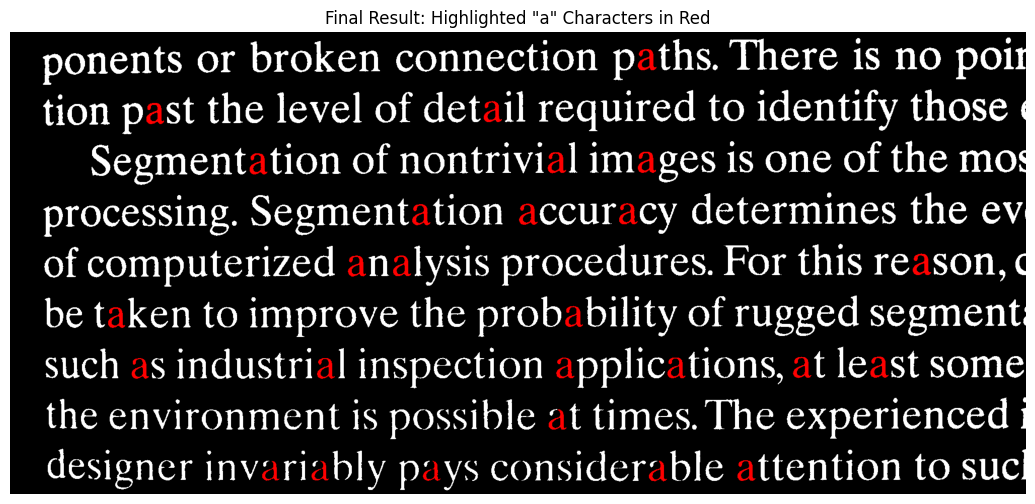

In [61]:
final_result = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
final_result[reconstruction_mask == 255] = [255, 0, 0]
plt.figure(figsize=(14, 6))
plt.imshow(final_result)
plt.title('Final Result: Highlighted "a" Characters in Red')
plt.axis('off')
plt.show()